# Import Modules

In [11]:
import pandas as pd
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim

import utils

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [13]:
source_X = pd.read_csv("./deep_occupancy_detection/data/4_X_train.csv").values
target_X = pd.read_csv("./deep_occupancy_detection/data/2_X_train.csv").values
source_y_task = pd.read_csv("./deep_occupancy_detection/data/4_Y_train.csv").values.reshape(-1)
target_y_task = pd.read_csv("./deep_occupancy_detection/data/2_Y_train.csv").values.reshape(-1)

scaler = preprocessing.StandardScaler()
source_X = scaler.fit_transform(source_X)
target_X = scaler.fit_transform(target_X)

In [14]:
source_X, source_y_task = utils.apply_sliding_window(source_X, source_y_task, filter_len=3)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=3)

train_source_X, _, _, train_source_y_task, _, _ = utils.train_val_test_split(source_X, source_y_task)
train_target_X, _, test_target_X, train_target_y_task, _, test_target_y_task = utils.train_val_test_split(target_X, target_y_task)
# TODO: test_target_X, test_target_y_task should be used in evaluation

In [15]:
source_loader, target_loader, train_source_y_task, train_source_X, train_target_X, train_target_y_task = utils.get_loader(train_source_X, train_target_X, train_source_y_task, train_target_y_task)
# TODO: Update utils.get_loader's docstring

test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
test_target_X = test_target_X.to(device)
test_target_y_task = test_target_y_task.to(device)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [16]:
hidden_size = 10
num_domains = 1
num_classes = 1

feature_extractor = utils.ManyToOneRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=1).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [17]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [18]:
num_epochs = 200

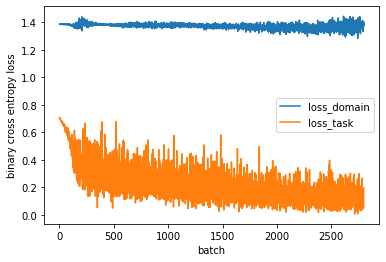

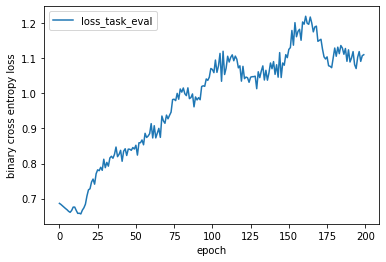

In [19]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, test_target_X, test_target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs, is_timeseries=False)